In [1]:
%load_ext autoreload
%autoreload 2

# Liesel-GAM Demo Notebook

## Setup and Imports

In [2]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
from liesel.goose import MCMCSpec, IWLSKernel
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.math.psd_kernels as tfk

import liesel_gam as gam
from liesel_gam.gp import GaussianProcessTerm

In [3]:
from scipy import stats

rng = np.random.default_rng(1)
n = 50
x = rng.uniform(-2, 2, n)


def f1(x):
    return -1.0 + 0.3 * (
        0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
    )


def f2(x):
    return -x + np.pi * np.sin(np.pi * x)


log_sigma = 0.1 + 0 * f1(x)
mu = f2(x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, n)

df = pd.DataFrame({"y": y, "x": x})

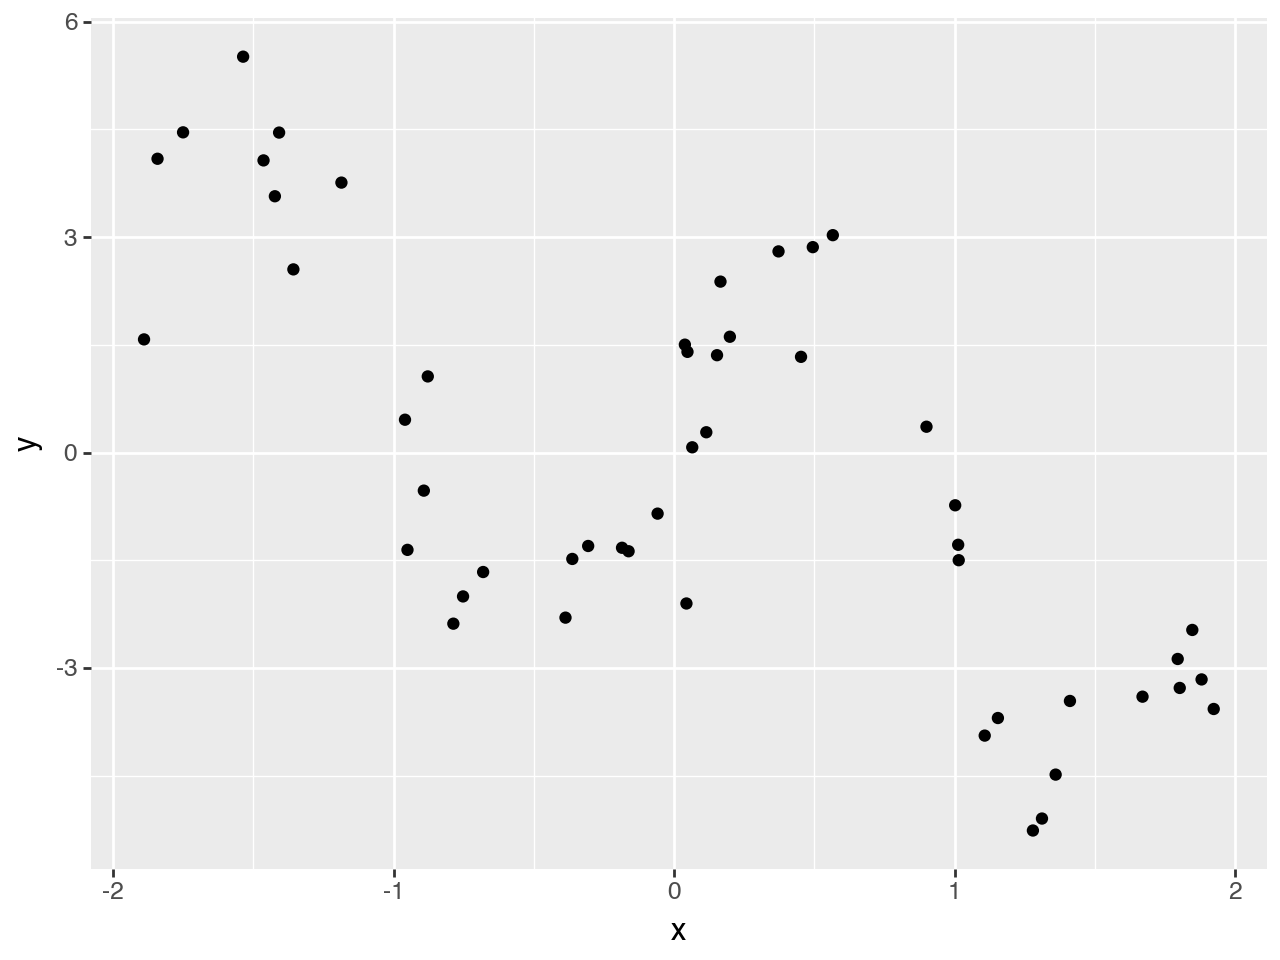

In [4]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [5]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Initialize GP terms

The `gam.GaussianProcessTerm` can be used to represent Gaussian process. It is a `lsl.Var` that
will automatically initialize a prior distribution based on the provided kernel constructor and parameters to the kernel.

In [6]:
# create hyper parameters for the kernel
ls = lsl.Var.new_param(1.0, lsl.Dist(tfd.Normal, loc=1.0, scale=0.5), "length_scale")
amp = lsl.Var.new_param(1.0, lsl.Dist(tfd.Normal, loc=1.0, scale=0.5), "amplitude")
ls_log = ls.transform(tfp.bijectors.Exp())
amp_log = amp.transform(tfp.bijectors.Exp())
ls_log.inference = MCMCSpec(IWLSKernel, kernel_group="b")
amp_log.inference = MCMCSpec(IWLSKernel, kernel_group="b")


# We need the inputs to be in the the shape (n, d), here d=1
x_input = lsl.Var.new_obs(x.reshape(-1, 1), name="x")

# Make a GP a predictor to the location
gp_loc = GaussianProcessTerm(
    x_input,
    tfk.ExponentiatedQuadratic,
    name="f(x)",
    amplitude=amp,
    length_scale=ls,
    kernel_diag=1e-4,
)
loc += gp_loc
scale += gam.Intercept(inference=MCMCSpec(IWLSKernel))

# We sample the values f(x) using a IWLS Kernel
gp_loc.inference = MCMCSpec(IWLSKernel)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="x_value").value


-93.27568


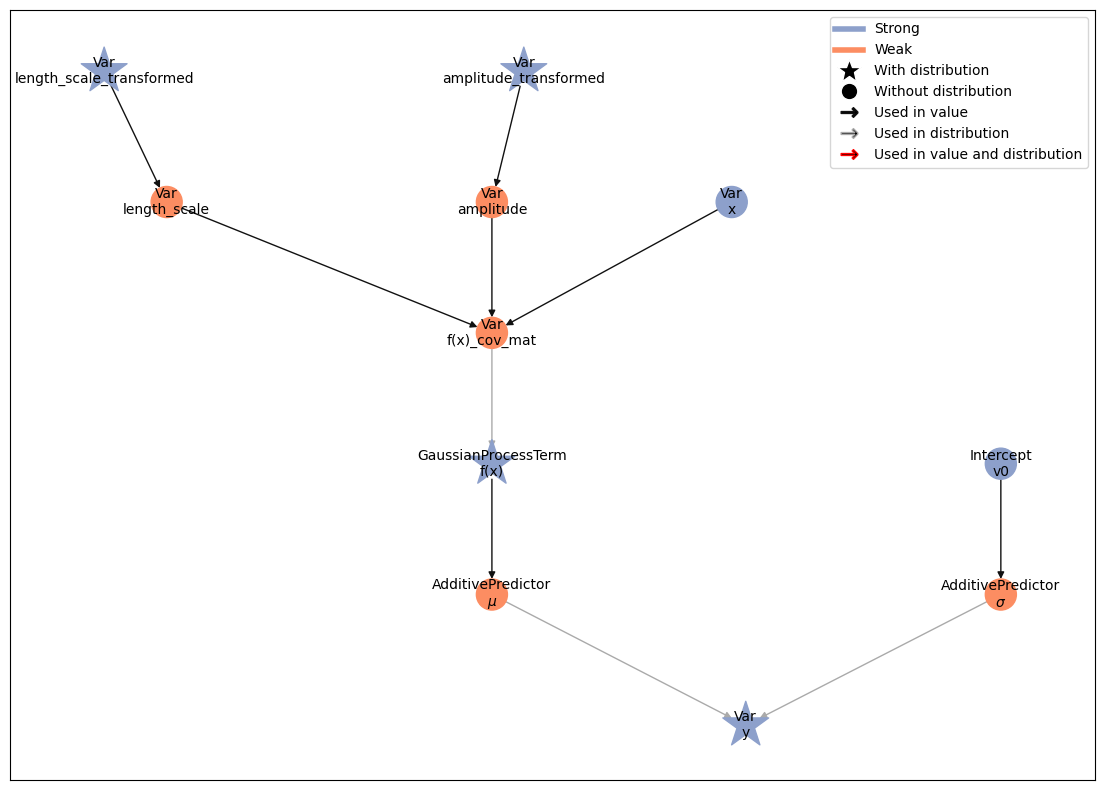

In [7]:
model = lsl.Model([y])
print(model.log_prob)
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=5000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'v0', 'f(x)', 'length_scale_transformed', 'amplitude_transformed'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  4.49chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 2, 0, 1, 3 / 400 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 35.63chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jit

### MCMC summary

In [9]:
summary = gs.Summary(results, deselected=["f(x)"])
summary

Parameter summary:

                                   kernel      mean        sd    q_0.05  \
parameter                index                                            
amplitude_transformed    ()     kernel_02  0.684108  0.141037  0.447957   
length_scale_transformed ()     kernel_02 -0.867066  0.205622 -1.240844   
v0                       ()     kernel_00 -0.072913  0.116289 -0.253606   

                                   q_0.5    q_0.95  sample_size     ess_bulk  \
parameter                index                                                 
amplitude_transformed    ()     0.684149  0.918123         2000  1586.181456   
length_scale_transformed ()    -0.851781 -0.565560         2000    40.732558   
v0                       ()    -0.078069  0.128149         2000  1239.375405   

                                   ess_tail      rhat  
parameter                index                         
amplitude_transformed    ()     1810.928055  1.000698  
length_scale_transformed ()      104.440824  1.074143  
v0                       ()     1651.382570  1.001234  

Error summary:

                                                   count relative
kernel    error_code error_msg           phase                   
kernel_00 90         nan acceptance prob warmup        1  0.00025
                                         posterior     0      0.0
kernel_02 90         nan acceptance prob warmup       17  0.00425
                                         posterior    22    0.011

### Show f(x)

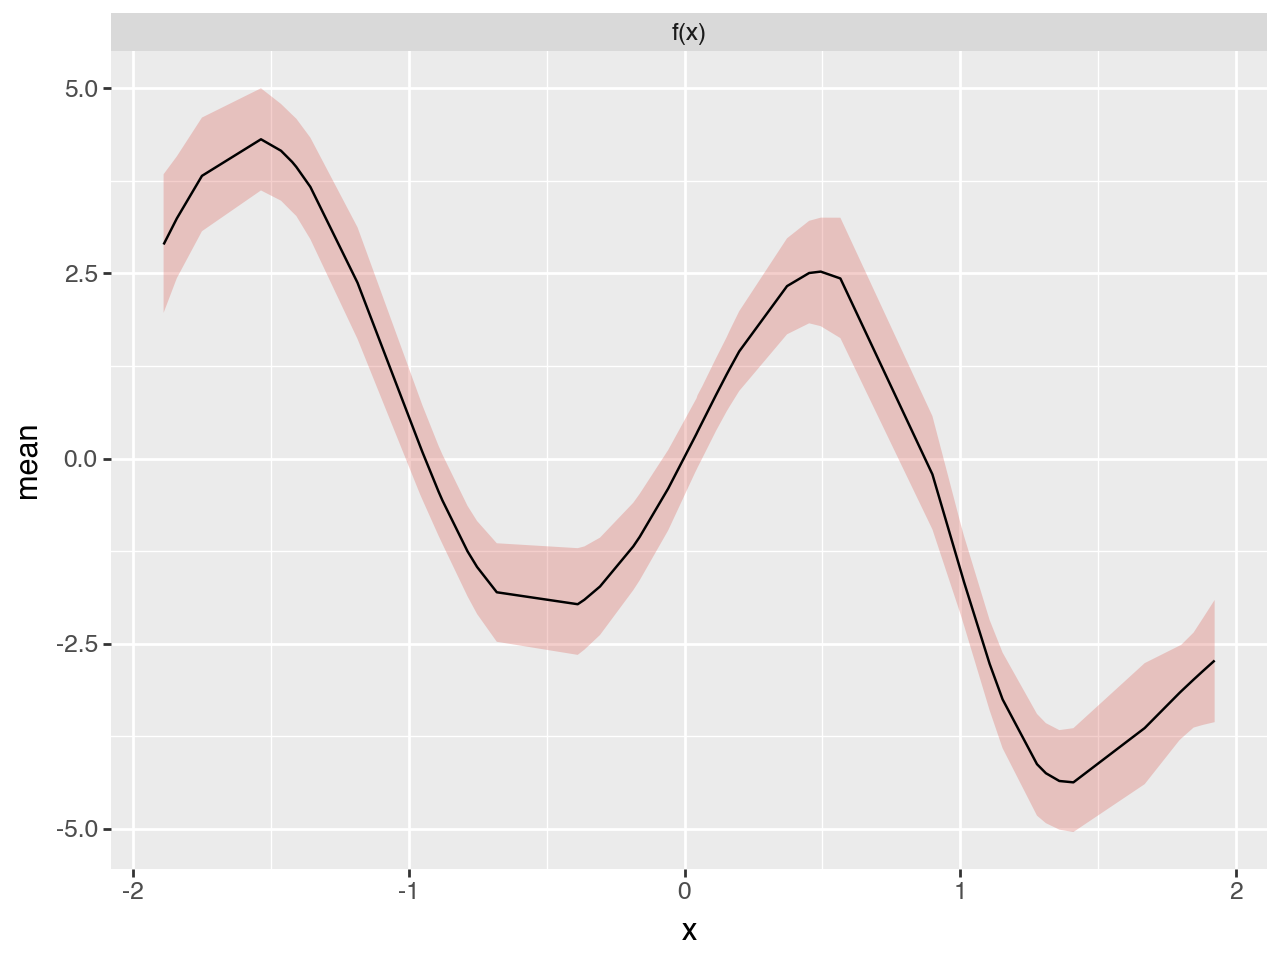

In [10]:
samples = {"f(x)": results.get_posterior_samples()["f(x)"]}
summary = gs.SamplesSummary(samples)
summary = summary.to_dataframe().reset_index()
summary["x"] = np.tile(x, len(samples))

select = summary["variable"].isin(["f(x)"])
(
    p9.ggplot(summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    # + p9.geom_line(p9.aes("x", "f"), pd.DataFrame({"x": x_grid, "f": f2(x_grid)}), linetype='dashed')
    # + p9.geom_line(p9.aes("x", "g"), pd.DataFrame({"x": x_grid, "g": f1(x_grid)}))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

## Inducing Point GPs

In [11]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [12]:
# create hyper parameters for the kernel
ls = lsl.Var.new_param(1.0, lsl.Dist(tfd.Normal, loc=1.0, scale=0.5), "length_scale")
amp = lsl.Var.new_param(1.0, lsl.Dist(tfd.Normal, loc=1.0, scale=0.5), "amplitude")
ls_log = ls.transform(tfp.bijectors.Exp())
amp_log = amp.transform(tfp.bijectors.Exp())
ls_log.inference = MCMCSpec(IWLSKernel, kernel_group="b")
amp_log.inference = MCMCSpec(IWLSKernel, kernel_group="b")


# We need the inputs to be in the the shape (n, d), here d=1
x_input = lsl.Var.new_obs(x.reshape(-1, 1), name="x")
x_ip = lsl.Var.new_obs(jnp.linspace(x.min(), x.max(), 10).reshape(-1, 1), name="x_ip")

# Make a GP a predictor to the location
gp_ip = GaussianProcessTerm(
    x_ip,
    tfk.ExponentiatedQuadratic,
    name="f(x_ip)",
    amplitude=amp,
    length_scale=ls,
    kernel_diag=1e-4,
)

# full_cov=False does not take full advantage of using only marginal cov(f(x))
gp_loc = gp_ip.predict_var(x_input, name="f(x)", full_cov=False)

loc += gp_loc
scale += gam.Intercept(inference=MCMCSpec(IWLSKernel))

# We sample the values f(x) and f(x_ip) using the smae IWLS Kernel
gp_loc.inference = MCMCSpec(IWLSKernel, kernel_group="f(x)")
gp_ip.inference = MCMCSpec(IWLSKernel, kernel_group="f(x)")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="x_value").value


-64.4585


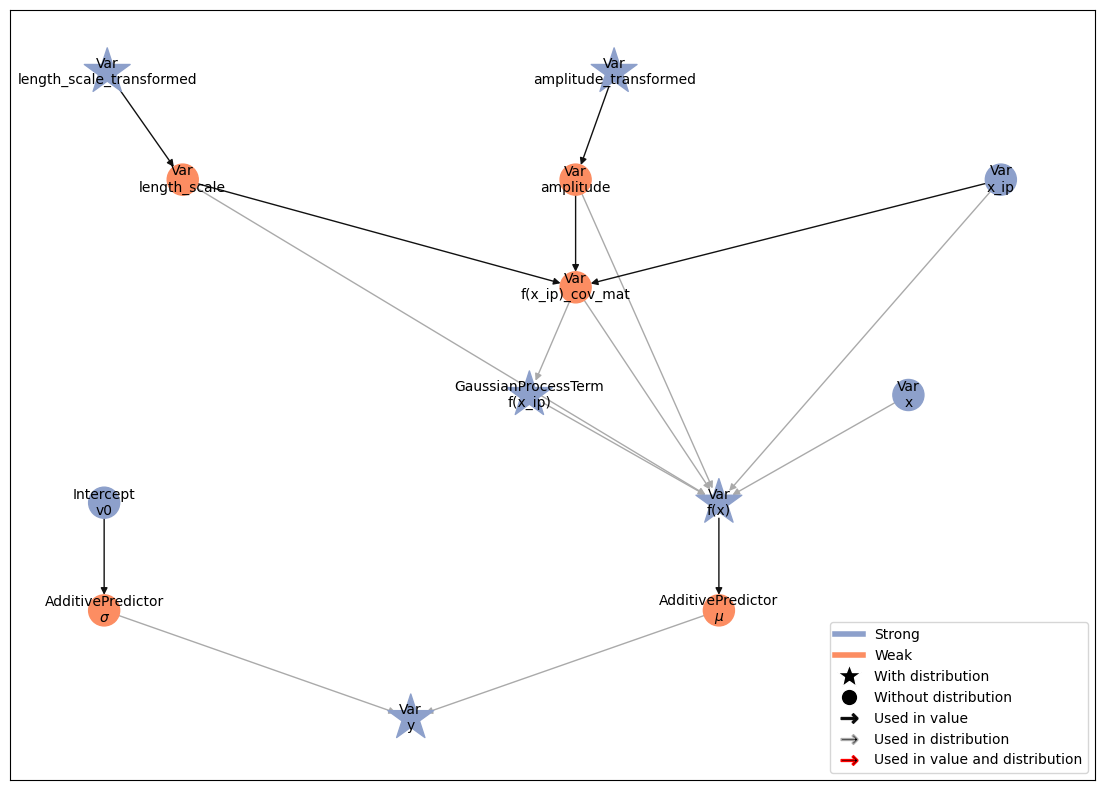

In [13]:
model = lsl.Model([y])
print(model.log_prob)
model.plot_vars()

## Run MCMC

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=5000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'v0', 'f(x)', 'f(x_ip)', 'length_scale_transformed', 'amplitude_transformed'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:07<00:00,  2.26chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 3, 9, 1, 23 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 0, 3, 0, 1 / 400 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 45.73chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - W

In [15]:
summary = gs.Summary(results, deselected=["f(x)"])
summary

Parameter summary:

                                   kernel      mean        sd    q_0.05  \
parameter                index                                            
amplitude_transformed    ()     kernel_02  0.689165  0.140723  0.454358   
f(x_ip)                  (0,)   kernel_01  2.944811  0.573853  1.995740   
                         (1,)   kernel_01  4.162462  0.397280  3.513006   
                         (2,)   kernel_01  0.945417  0.426504  0.235723   
                         (3,)   kernel_01 -2.013054  0.450073 -2.729410   
                         (4,)   kernel_01 -1.227447  0.370238 -1.811771   
                         (5,)   kernel_01  1.628111  0.336749  1.069263   
                         (6,)   kernel_01  2.099837  0.559532  1.234562   
                         (7,)   kernel_01 -2.418809  0.356766 -2.996877   
                         (8,)   kernel_01 -4.324275  0.467006 -5.064404   
                         (9,)   kernel_01 -2.642473  0.471176 -3.415205   
length_scale_transformed ()     kernel_02 -0.855383  0.223428 -1.271746   
v0                       ()     kernel_00 -0.092223  0.145181 -0.321582   

                                   q_0.5    q_0.95  sample_size     ess_bulk  \
parameter                index                                                 
amplitude_transformed    ()     0.685847  0.921704         2000   947.620626   
f(x_ip)                  (0,)   2.956418  3.860361         2000   545.247104   
                         (1,)   4.166389  4.807794         2000   852.784050   
                         (2,)   0.969700  1.607593         2000   809.939462   
                         (3,)  -2.007018 -1.258267         2000  1406.311413   
                         (4,)  -1.230948 -0.607388         2000  1180.464395   
                         (5,)   1.639300  2.165072         2000  1261.289380   
                         (6,)   2.106394  3.063914         2000    45.424128   
                         (7,)  -2.411551 -1.843982         2000   769.410537   
                         (8,)  -4.336709 -3.534103         2000  1148.711492   
                         (9,)  -2.654276 -1.887696         2000   987.009897   
length_scale_transformed ()    -0.820390 -0.538130         2000     9.849671   
v0                       ()    -0.088109  0.129773         2000    88.714492   

                                   ess_tail      rhat  
parameter                index                         
amplitude_transformed    ()     1610.075318  1.005017  
f(x_ip)                  (0,)   1410.539211  1.019715  
                         (1,)   1502.855833  1.014403  
                         (2,)   1104.944721  1.009076  
                         (3,)   1783.944490  1.003239  
                         (4,)   1636.051762  1.003204  
                         (5,)   1556.904685  1.005581  
                         (6,)    404.107154  1.060984  
                         (7,)   1478.341714  1.009737  
                         (8,)   1643.912981  1.004409  
                         (9,)   1658.686274  1.004765  
length_scale_transformed ()       38.103391  1.337984  
v0                       ()       57.594572  1.036192  

Error summary:

                                                   count relative
kernel    error_code error_msg           phase                   
kernel_00 90         nan acceptance prob warmup        1  0.00025
                                         posterior     0      0.0
kernel_01 90         nan acceptance prob warmup       36    0.009
                                         posterior     0      0.0
kernel_02 90         nan acceptance prob warmup       14   0.0035
                                         posterior     0      0.0

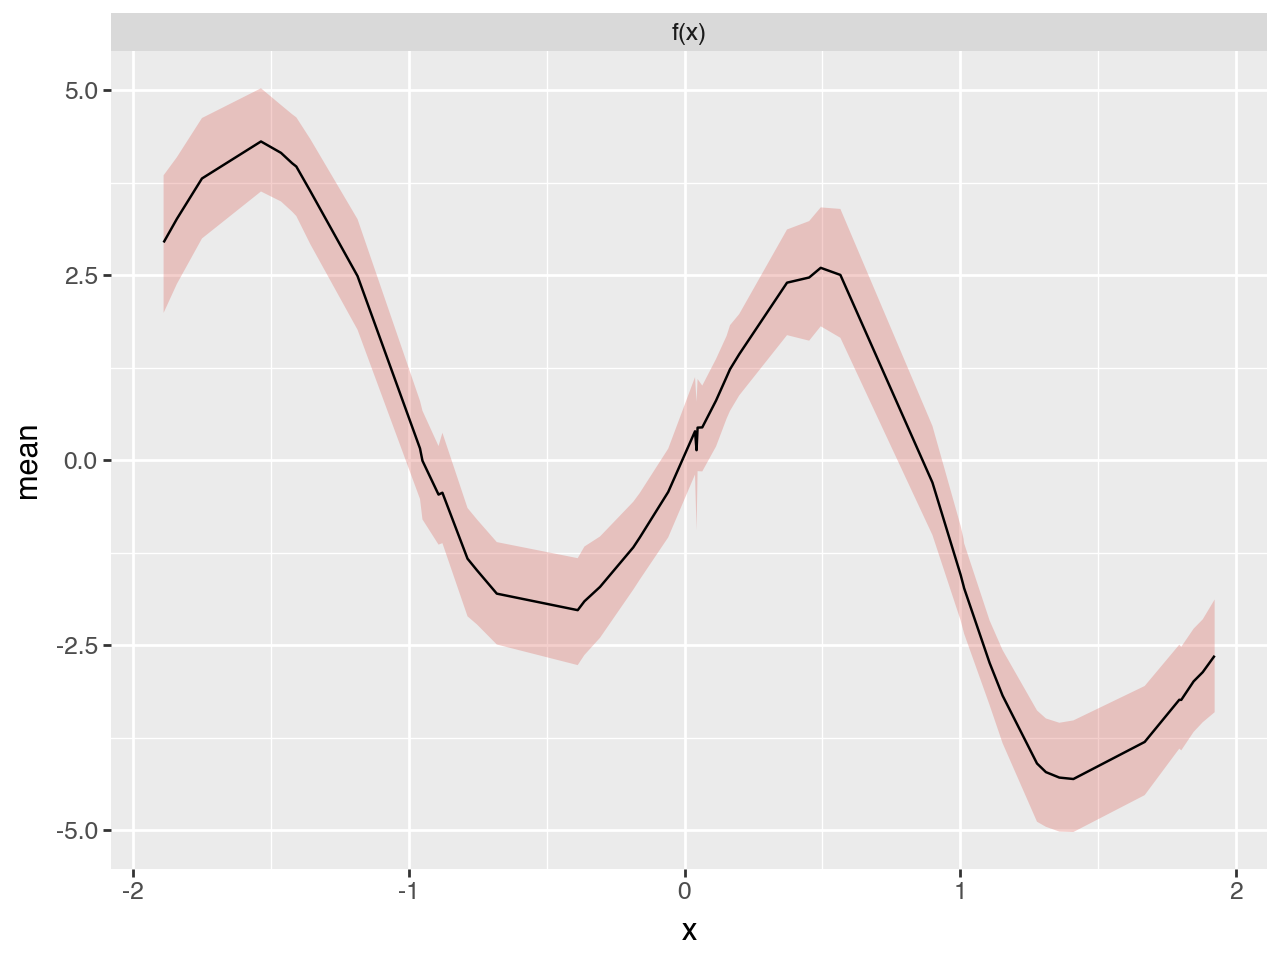

In [16]:
# Show f(x)
samples = {"f(x)": results.get_posterior_samples()["f(x)"]}
summary = gs.SamplesSummary(samples)
summary = summary.to_dataframe().reset_index()
summary["x"] = np.tile(x, len(samples))

select = summary["variable"].isin(["f(x)"])
(
    p9.ggplot(summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    # + p9.geom_line(p9.aes("x", "f"), pd.DataFrame({"x": x_grid, "f": f2(x_grid)}), linetype='dashed')
    # + p9.geom_line(p9.aes("x", "g"), pd.DataFrame({"x": x_grid, "g": f1(x_grid)}))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

Above, we cannot access the values of the parameters of the distribution on f(x), because they are calculated in the dist node.
Is that wrong? could we do predictions wrt to the parameters of f(x).dist_node?

therefor, we can make the parameters of the distribution on f(x) accessible by using the `make_param_vars` argument in the `GaussianProcessTerm.predict_var` method.

## IP with parameter nodes

liesel.model.model - INFO - Converted dtype of Value(name="x_value").value


-64.4585


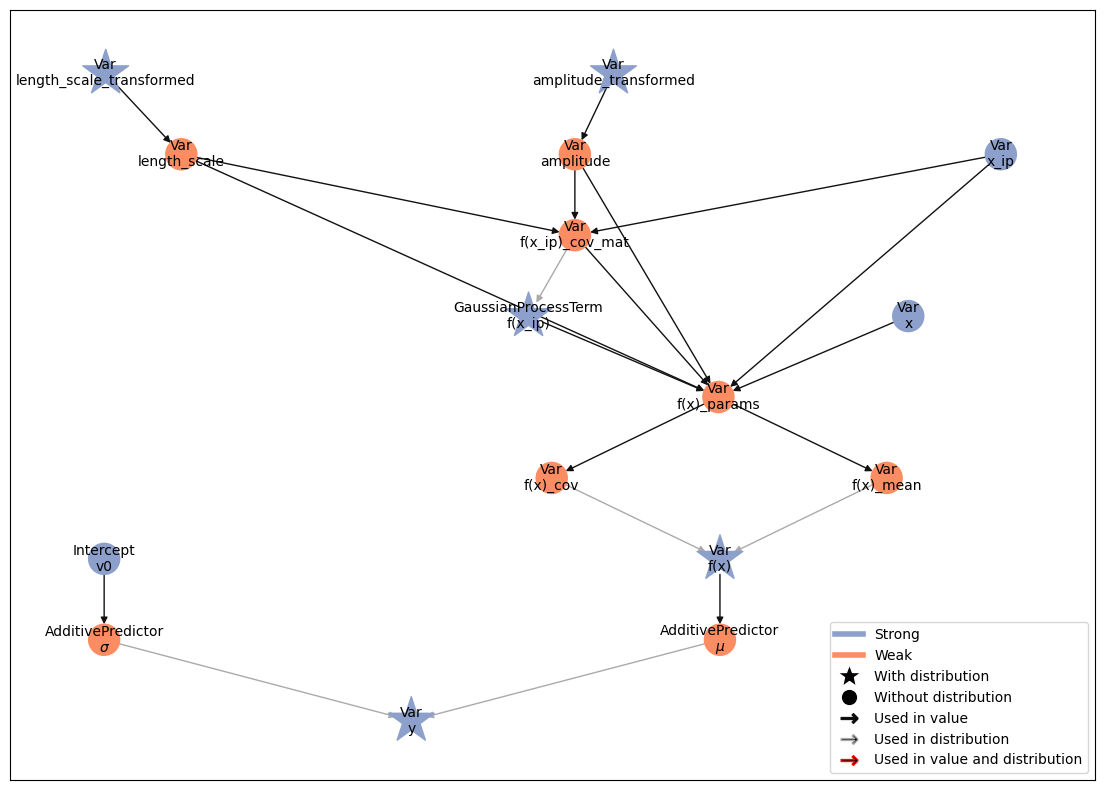

In [17]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

# create hyper parameters for the kernel
ls = lsl.Var.new_param(1.0, lsl.Dist(tfd.Normal, loc=1.0, scale=0.5), "length_scale")
amp = lsl.Var.new_param(1.0, lsl.Dist(tfd.Normal, loc=1.0, scale=0.5), "amplitude")
ls_log = ls.transform(tfp.bijectors.Exp())
amp_log = amp.transform(tfp.bijectors.Exp())
ls_log.inference = MCMCSpec(IWLSKernel, kernel_group="b")
amp_log.inference = MCMCSpec(IWLSKernel, kernel_group="b")


# We need the inputs to be in the the shape (n, d), here d=1
x_input = lsl.Var.new_obs(x.reshape(-1, 1), name="x")
x_ip = lsl.Var.new_obs(jnp.linspace(x.min(), x.max(), 10).reshape(-1, 1), name="x_ip")

# Make a GP a predictor to the location
gp_ip = GaussianProcessTerm(
    x_ip,
    tfk.ExponentiatedQuadratic,
    name="f(x_ip)",
    amplitude=amp,
    length_scale=ls,
    kernel_diag=1e-4,
)

# False not supported yet
gp_loc = gp_ip.predict_var(x_input, name="f(x)", full_cov=False, make_param_vars=True)

loc += gp_loc
scale += gam.Intercept(inference=MCMCSpec(IWLSKernel))

# We sample the values f(x) and f(x_ip) using the smae IWLS Kernel
gp_loc.inference = MCMCSpec(IWLSKernel, kernel_group="f(x)")
gp_ip.inference = MCMCSpec(IWLSKernel, kernel_group="f(x)")

model = lsl.Model([y])
print(model.log_prob)
model.plot_vars()

In [18]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=5000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'v0', 'f(x)', 'f(x_ip)', 'length_scale_transformed', 'amplitude_transformed'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.35chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 3, 5, 1, 23 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 0, 5, 0, 1 / 400 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 46.35chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - W

In [19]:
summary = gs.Summary(results, deselected=["f(x)"])
summary

Parameter summary:

                                   kernel      mean        sd    q_0.05  \
parameter                index                                            
amplitude_transformed    ()     kernel_02  0.687807  0.140728  0.454559   
f(x_ip)                  (0,)   kernel_01  2.944484  0.573224  1.982551   
                         (1,)   kernel_01  4.160075  0.400324  3.506443   
                         (2,)   kernel_01  0.947564  0.423762  0.234122   
                         (3,)   kernel_01 -2.012774  0.448198 -2.718389   
                         (4,)   kernel_01 -1.226142  0.370554 -1.818101   
                         (5,)   kernel_01  1.624663  0.334740  1.068643   
                         (6,)   kernel_01  2.092744  0.560130  1.218750   
                         (7,)   kernel_01 -2.416320  0.355881 -2.994579   
                         (8,)   kernel_01 -4.326616  0.466881 -5.065918   
                         (9,)   kernel_01 -2.638886  0.469131 -3.400671   
length_scale_transformed ()     kernel_02 -0.854027  0.219722 -1.260529   
v0                       ()     kernel_00 -0.088847  0.137716 -0.313561   

                                   q_0.5    q_0.95  sample_size     ess_bulk  \
parameter                index                                                 
amplitude_transformed    ()     0.684961  0.924193         2000  1246.768284   
f(x_ip)                  (0,)   2.957547  3.847653         2000   692.075653   
                         (1,)   4.162511  4.803631         2000   855.556915   
                         (2,)   0.970584  1.613217         2000   870.118524   
                         (3,)  -2.010931 -1.260680         2000  1417.178177   
                         (4,)  -1.230275 -0.614618         2000  1199.158028   
                         (5,)   1.636954  2.169338         2000  1266.827822   
                         (6,)   2.100554  3.053321         2000    44.817198   
                         (7,)  -2.405616 -1.848829         2000  1124.095260   
                         (8,)  -4.334929 -3.534894         2000  1190.536793   
                         (9,)  -2.650303 -1.887756         2000   993.745367   
length_scale_transformed ()    -0.818967 -0.535422         2000    10.266810   
v0                       ()    -0.087225  0.129627         2000   115.850852   

                                   ess_tail      rhat  
parameter                index                         
amplitude_transformed    ()     1660.849284  1.004971  
f(x_ip)                  (0,)   1339.600330  1.017147  
                         (1,)   1586.908530  1.013489  
                         (2,)   1182.502653  1.008353  
                         (3,)   1774.137495  1.003066  
                         (4,)   1709.064352  1.002911  
                         (5,)   1486.293627  1.004430  
                         (6,)    305.486730  1.060534  
                         (7,)   1626.594760  1.008881  
                         (8,)   1636.539537  1.004964  
                         (9,)   1734.101069  1.005207  
length_scale_transformed ()       49.721797  1.318505  
v0                       ()      100.295945  1.029143  

Error summary:

                                                   count relative
kernel    error_code error_msg           phase                   
kernel_00 90         nan acceptance prob warmup        1  0.00025
                                         posterior     0      0.0
kernel_01 90         nan acceptance prob warmup       32    0.008
                                         posterior     0      0.0
kernel_02 90         nan acceptance prob warmup       16    0.004
                                         posterior     0      0.0

## Predictions

In [20]:
samples = results.get_posterior_samples()


### Now, we can make predictions and get the predicted mean and variance of f(x) for new values of x.

In [21]:
x_grid = jnp.linspace(x.min(), x.max(), 200).reshape(-1, 1)
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=[
        "f(x)_mean",
    ],
    newdata={"x": x_grid.reshape(-1, 1)},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

### Predict variables at new x values

In [22]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,f(x)_mean,f(x)_mean[0],"(0,)",2000,2.944488,0.328558,0.573200,1.017153,691.747962,1339.600330,0.021630,0.009569,1.982638,2.957521,3.847601,2.053502,3.901278,-1.889764
1,f(x)_mean,f(x)_mean[1],"(1,)",2000,3.060779,0.306368,0.553506,1.016684,712.131920,1367.307130,0.020544,0.009224,2.141621,3.075867,3.935192,2.224945,4.003517,-1.870604
2,f(x)_mean,f(x)_mean[2],"(2,)",2000,3.175129,0.285026,0.533878,1.016048,761.033648,1487.085625,0.019305,0.008904,2.277307,3.188436,4.019284,2.355538,4.073198,-1.851445
3,f(x)_mean,f(x)_mean[3],"(3,)",2000,3.286959,0.264837,0.514623,1.015207,847.113535,1392.340747,0.017713,0.008607,2.423174,3.300776,4.100174,2.527087,4.192601,-1.832286
4,f(x)_mean,f(x)_mean[4],"(4,)",2000,3.395714,0.246062,0.496046,1.014255,932.678083,1219.607387,0.016211,0.008330,2.554664,3.409239,4.185965,2.609360,4.219792,-1.813126


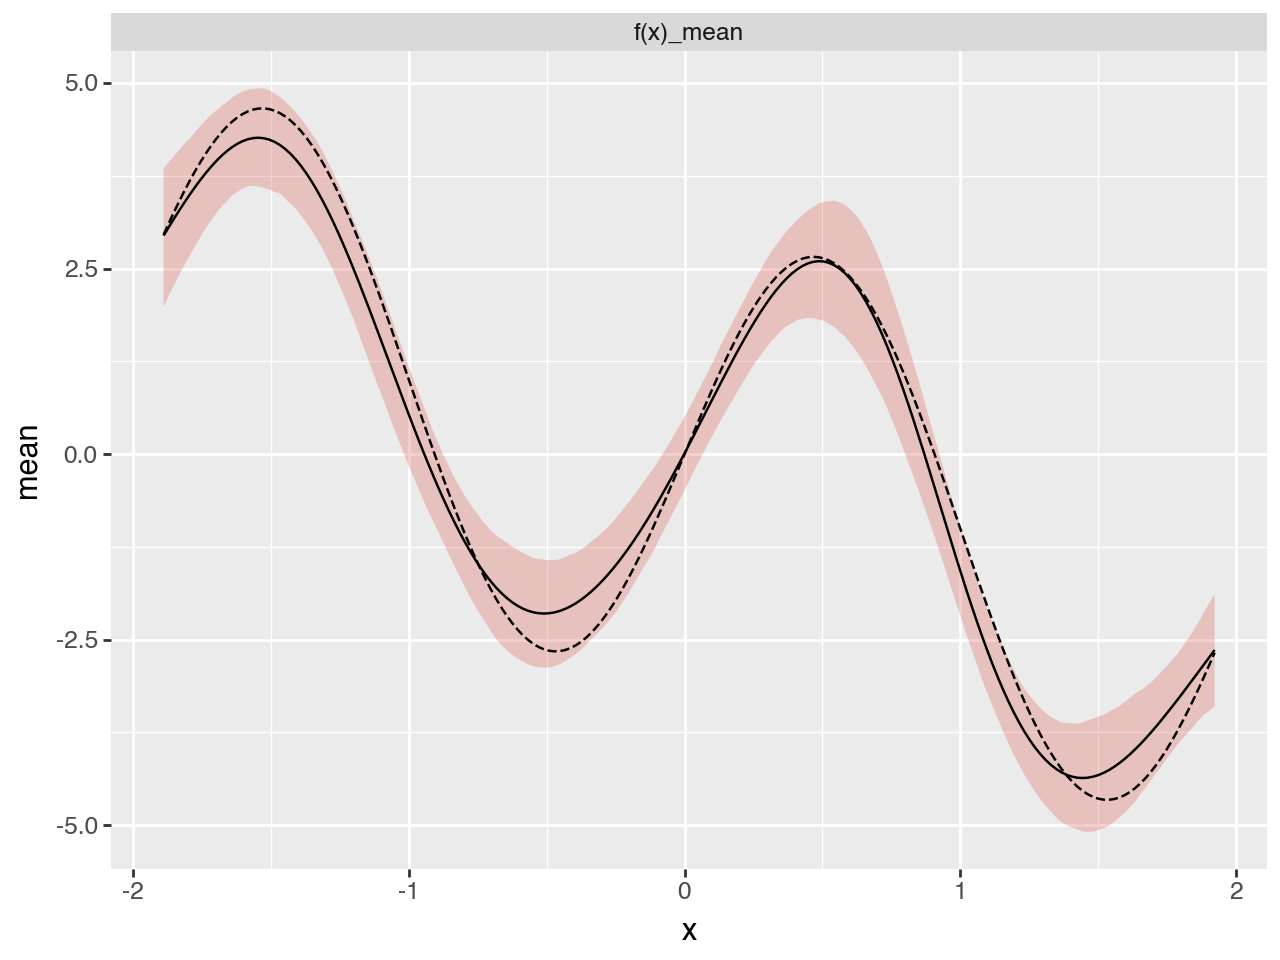

In [23]:
select = predictions_summary["variable"].isin(["f(x)_mean"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.geom_line(
        p9.aes("x", "f"),
        pd.DataFrame({"x": x_grid.flatten(), "f": f2(x_grid.flatten())}),
        linetype="dashed",
    )
    # + p9.geom_line(p9.aes("x", "g"), pd.DataFrame({"x": x_grid, "g": f1(x_grid)}))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)